In [1]:
import socket
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

In [2]:
def le_dados_imu(N, func=None, endereco = "shaka", porta=1234):
    dd = []
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((endereco, porta))
        for i in range(N):
            data = s.recv(32)
            ax = int.from_bytes(data[0:2], byteorder='big', signed=True)
            ay = int.from_bytes(data[2:4], byteorder='big', signed=True) 
            az = int.from_bytes(data[4:6], byteorder='big', signed=True) 
            temp = int.from_bytes(data[6:8], byteorder='big', signed=True) 
            wx = int.from_bytes(data[8:10], byteorder='big', signed=True)
            wy = int.from_bytes(data[10:12], byteorder='big', signed=True)
            wz = int.from_bytes(data[12:14], byteorder='big', signed=True)
            mx = int.from_bytes(data[14:16], byteorder='big', signed=True)
            my = int.from_bytes(data[16:18], byteorder='big', signed=True)
            mz = int.from_bytes(data[18:20], byteorder='big', signed=True)
            t = int.from_bytes(data[-8:], byteorder='little', signed=False)
            dd.append([ax, ay, az, wx, wy, wz, mx, my, mz, temp, t])
            if func:
                func(i)
    return dd

In [3]:
res2x = np.loadtxt("res2x.txt")
Q = np.loadtxt("Q.txt")
W = np.loadtxt("W.txt")
H = np.loadtxt("H.txt")
scale = 0.000598
gy_scale= 0.001064724
mag_scale = 0.001810
print(res2x)

[-181.4548672  -151.19968288  119.58441564    0.99810697    0.99971396
    0.98932928]


In [ ]:
dados = le_dados_imu(6000, lambda i : print("Coletando dados: " + str(int(100*(i+1)/6000))+ "%", end="\r"))
np.savetxt("GyroParado.txt", np.array(dados)[:,3:6])


In [7]:

gp = np.loadtxt("GyroParado.txt")
gyOffset = np.average(gp,0)
print(gyOffset)
np.savetxt("gyOffset.txt",gyOffset)

[-34.82366667   5.474      -16.5495    ]


In [4]:
def getRobotGy(gy):
    return (Q@(np.array(gy)-gyOffset))

In [5]:
def getRobotMag(mag):
    return W@(mag-H)

[-1.692000e+03  2.020000e+02  1.636800e+04 -3.200000e+01  6.000000e+00
 -1.600000e+01 -1.260000e+02  1.100000e+02 -1.000000e+02  2.227000e+03
  1.748444e+18]


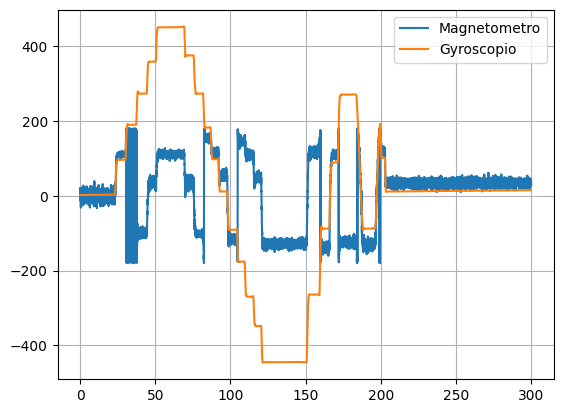

In [8]:
allData = np.loadtxt("orientados.txt")

gy = allData[:,3:6]
mag = allData[:,6:9]
Time = allData[:,10]
print(allData[0])
W_Ant, theta = 0,0

T0= Time[0]
T_ant = T0
X = np.zeros(len(Time))
YGy = np.zeros(len(Time))
Ymag = np.zeros(len(Time))
Wl = np.zeros(len(Time))
for i in range(len(Time)):
    X[i] = (Time[i]-T0)/1e9 # ns to s
    #print(Time[i])
    dt =(Time[i] - Time[i-1])/1e9
    #print(dt)
    Wi =getRobotGy(gy[i])
    Wl[i] = Wi[2]*gy_scale 
    wz = Wi[2]*180/np.pi*gy_scale

    theta += (wz+W_Ant)/2*dt
    W_Ant=wz
    YGy[i]=theta
    magcor = getRobotMag(mag[i])
    Ymag[i]=np.arctan2(magcor[0],magcor[1])*180/np.pi

mag0 = np.average(Ymag[:500])
for i in range(len(Time)):
    Ymag[i] = (Ymag[i]-mag0+180)%360-180
plt.plot(X,Ymag,label="Magnetometro")
plt.plot(X,YGy,label="Gyroscopio")
plt.legend()
plt.grid(True)
plt.show()

0.000673185929231597
6.669357769704175


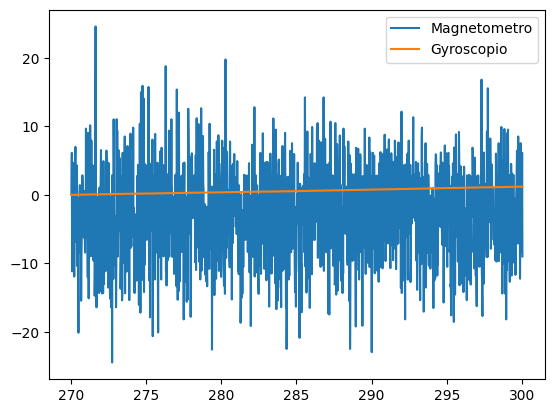

In [9]:

plt.plot(X[-1500:],Ymag[-1500:]-Ymag[-1500],label="Magnetometro")
plt.plot(X[-1500:],YGy[-1500:]-YGy[-1500],label="Gyroscopio")
plt.legend()
#plt.plot(X[-1500:],Wl[-1500:])
print(np.std(Wl[-1500:]))
print(np.std(Ymag[-1500:]))

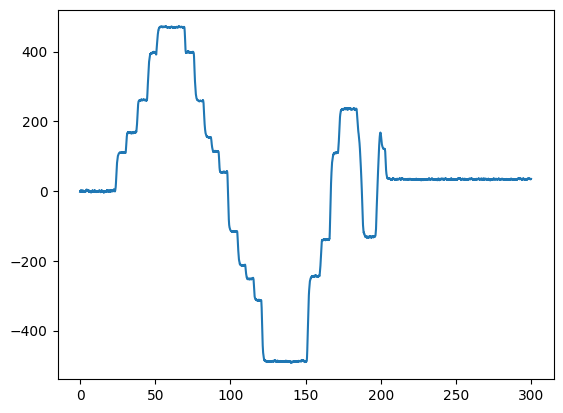

In [10]:
f_s = 50
fc = 1/3
alpha = np.exp(-2*np.pi*fc/f_s)

YmagFiltered = np.zeros(len(Time))
YmagFiltered[0] = Ymag[0]
for i in range(1,len(Time)):
    di = (Ymag[i]-YmagFiltered[i-1]+180)%360-180
    YmagFiltered[i] = YmagFiltered[i-1] + (1-alpha) * di
    
plt.plot(X,YmagFiltered,label="Magnetometro Filtrado")

In [52]:
class KalmanFilter(object):

    ## Deve ser passado o valor de sigma_omega**2 na incerteza
    def __init__(self, callback, t0, rumo0, incerteza0):

        self._callback = callback

        # Estado inicial: [theta, omega]
        self._mu = np.array([rumo0, 0.0])  # rumo inicial, velocidade angular 0
        self._sigma = np.array([[incerteza0, 0.0], [0.0, 0.0]])  # incerteza no rumo apenas; incerteza0 já está ao quadrado
        self._t = t0  # instante inicial

        # Parâmetros do filtro    refazer os comentários
        self._sigma_omega = incerteza0  
        self._sigma_theta = 6.669357769704175 #em graus
        self._Q = self._sigma_theta  # ruído de medida do magnetômetro    ### renomear

        ## Etapa de predição 
        # Aqui precisamos das matrizes A, B, R; trabalhamos com o estado atual e a entrada de controle

    def predict(self, dt, vel_ang): #CHECK

        # Matriz de dinâmica
        A = np.array([[1, dt/2.0],
                        [0.0, 0.0]])
        
        # Matriz de atuação
        B = np.array([[dt/2.0],
                        [1.0]])

        # Matriz de covariância
        R = self._sigma_omega * np.array([[dt**2/4.0, dt/2.0],
                                            [dt/2.0, 1.0]])

        # Entrada de controle
        u = np.array([vel_ang])
        
        self._mu = A @ self._mu + B @ u
        self._sigma = A @ self._sigma @ A.T + R
    
        return self._mu
    
    def angle_diff(self, a, b):
        
        d = a - b
        normalized = (d + np.pi) % (2 * np.pi) - np.pi
        return normalized
    
    def update(self, ang_rumo):

        C = np.array([1.0, 0.0]).reshape((1,2))

        S = C @ self._sigma @ C.T + self._Q

        K = self._sigma @ C.T @ np.linalg.inv(S)

        theta_predicted = C @ self._mu.T

        obser_diff = self.angle_diff(ang_rumo, theta_predicted)

        self._mu = self._mu + K @ obser_diff
        self._sigma = (np.identity(2) - K @ C) @ self._sigma
        
        return self._mu



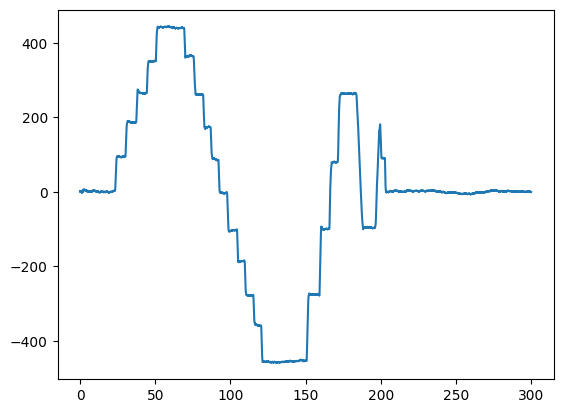

In [53]:

KF = KalmanFilter(100, 0, 0, 0.0386)

theta = Ymag
omega = Wl
x_pred = np.zeros(len(Time))
y_pred = np.zeros(len(Time))
x_up = np.zeros(len(Time))
y_up = np.zeros(len(Time))

x_pred[0], y_pred[0] = KF.predict(0, omega[0])
x_up[0], y_up[0] = KF.update(theta[0])
for i in range(1,len(Time)):
    
    x_pred[i], y_pred[i] = KF.predict(X[i]-X[i-1], omega[i])
    x_up[i], y_up[i] = KF.update(theta[i])



    #print("Valor previsto:" , x_pred[i], y_pred[i])
    #print("Valor intermediário:", x_up[i], y_up[i])

plt.plot(X,x_pred*180/np.pi,label="Fusão")



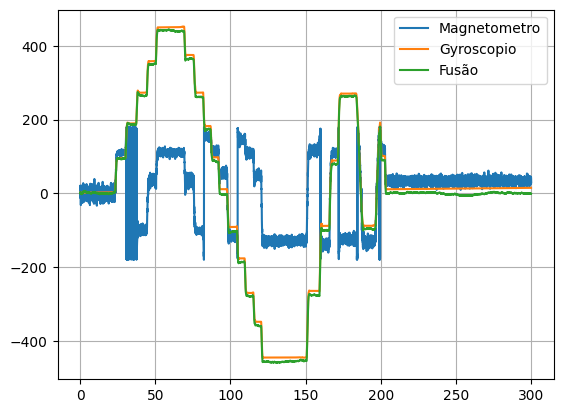

In [56]:
#ca = np.zeros_like(X)-450

#plt.plot(X,YmagFiltered,label="Magnetometro Filtrado")
plt.plot(X,Ymag,label="Magnetometro")
plt.plot(X,YGy,label="Gyroscopio")
plt.plot(X,x_pred*180/np.pi,label="Fusão")
#plt.plot(X,ca)
plt.legend()
plt.grid(True)
plt.show()
